In [2]:
%pip install ipynb

# Run the above line to get the preprocess() function from Preprocessing.ipynb

Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from ipynb.fs.full.Preprocessing import preprocess

In [97]:
train_x, train_y, test_x, test_y = preprocess(100000)

train_y = train_y.reshape(-1, 1)
train_y = train_y.astype('int')

train_x = train_x.astype("float")
test_x = test_x.astype("float")

test_y = test_y.reshape(-1, 1)
test_y = test_y.astype('int')

In [98]:
#We have 12 features, add 1 column (as 1st row) to the train_x data 
#train_x = np.c_[np.ones( train_x.shape[0] ), train_x]
train_x.shape

(79641, 12)

In [99]:
def LogisticRegressionTrain(train_x, train_y):
    number_of_classes = 3
    number_of_features = train_x.shape[1]
    number_of_samples = train_x.shape[0]
    learning_rate = 0.5
    
    assert(number_of_features == 12)
    
    # One-hot encode the classes for training
    # E.g., if class array is [0, 0, 1, 0, 2]
    # Convert to [[1,0,0], [1,0,0], [0,1,0], [1,0,0],[0,0,1]]
    one_hot_encoded = []

    for arr in (train_y):
        if (arr == [0]):
            one_hot_encoded.append([1, 0, 0,])
        elif (arr == [1]):
            one_hot_encoded.append([0, 1, 0,])
        elif (arr == [2]):
            one_hot_encoded.append([0, 0, 1,])
        else:
            print("error")

    encoded_train_y = np.array(one_hot_encoded)

    # Initialize the weights
    weights = np.random.rand(number_of_features, number_of_classes)
    bias = np.random.randn(1, number_of_classes)
    
    iteration_count = 1000
    for i in range(1, iteration_count + 1):
        # Get the Log-odds (logit)
        logits = train_x @ weights + bias

        # Calculate the probability of y 
        # Pr(Y = 0, 1, or 2 | X = train_x)
        max_value = np.max(logits, axis =1, keepdims=True)
        numerator = np.exp(logits - max_value)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        y_probability = numerator / denominator
                
        # Calculate the gradient vectors 
        
        # Gradient of the weights
        dW = (1 / number_of_samples) * (train_x.T @ (y_probability - encoded_train_y))
        
        # Gradient of the bias
        db = (1 / number_of_samples) * np.sum((y_probability - encoded_train_y), axis=0, keepdims=True)
        
        # We use gradient descent to update the weights and bias because
        # the number of samples is quite high. If we had used Newton-Raphson 
        # method, we would have had to compute the inverse of 100,000x100,000
        # matrix which is impossible due to hardware insufficiencies.
        weights -= (dW * learning_rate)
        bias -= (db * learning_rate)
        
    return weights, bias
        

    

In [100]:
def make_prediction(feature, weights, bias, threshold=0.5):
    logits = feature @ weights + bias

    max_value = np.max(logits, axis =1, keepdims=True)
    numerator = np.exp(logits - max_value)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    y_probability = numerator / denominator
    
    return np.argmax(y_probability, axis=1)

In [108]:
import seaborn as sn

def confusion_matrix(test_x, test_y, weights, bias):
    prediction = make_prediction(test_x, weights, bias)    
    confusion_matrix = np.zeros((3, 3), dtype=int)
    
    accurate_prediction_count = 0
    for i, pred in enumerate(prediction):
        if test_y[i][0] == 0:
            if pred == 0: 
                confusion_matrix[0][0] += 1
            elif pred == 1:
                confusion_matrix[0][1] += 1
            elif pred == 2:
                confusion_matrix[0][2] += 1
        
        elif test_y[i][0] == 1:
            if pred == 0:
                confusion_matrix[1][0] += 1
            elif pred == 1:
                confusion_matrix[1][1] += 1
            elif pred == 2:
                confusion_matrix[1][2] += 1
                
        elif test_y[i][0] == 2:
            if pred == 0:
                confusion_matrix[2][0] += 1
            elif pred == 1:
                confusion_matrix[2][1] += 1
            elif pred == 2:
                confusion_matrix[2][2] += 1
        
        if pred == test_y[i][0]:
            accurate_prediction_count += 1
            
    
    s = sn.heatmap(confusion_matrix, annot=True, fmt='g')
    s.set(xlabel='Predicted Labels', ylabel='True Labels')
    plt.show()
    return accurate_prediction_count / test_y.shape[0] * 100 
        


In [109]:
weights, bias = LogisticRegressionTrain(train_x, train_y)

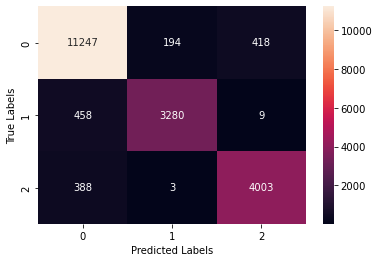

Accuracy is: 92.65 %


In [110]:
acc = confusion_matrix(test_x, test_y, weights, bias)

print("Accuracy is:", acc, "%")